# Best Practices

# Setup

In [52]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [53]:
# load data
data = loadmat('ex5data1.mat')

X, y = data['X'], data['y'][:,0]
Xtest, ytest = data['Xtest'], data['ytest'][:,0]
Xval, yval = data['Xval'], data['yval'][:,0]

m = y.size

Text(0, 0.5, 'Water Flowing Out of the Dam (y)')

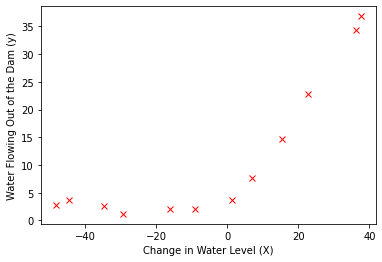

In [54]:
# plot
plt.plot(X, y, 'rx')
plt.xlabel('Change in Water Level (X)')
plt.ylabel('Water Flowing Out of the Dam (y)')

# Regularized Linear Regression

In [81]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):

    h = X.dot(theta)

    J = (1/(2*m)) * np.sum(np.square(h - y)) + lambda_/(2*m) * np.sum(np.square(theta[1:]))

    grad = (1/m) * (h - y).dot(X)

    grad[1:] = grad[1:] + lambda_/m * theta[1:] 

    return J, grad

In [56]:
# test it - looks right
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Cost at theta = [1, 1]:\t   %f ' % J)
print('This value should be about 303.993192)\n' % J)


Cost at theta = [1, 1]:	   303.993192 
This value should be about 303.993192)



In [57]:
# also looks good
print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))
print(' (this value should be about [-15.303016, 598.250744])\n')

Gradient at theta = [1, 1]:  [-15.219682, 598.250744] 
 (this value should be about [-15.303016, 598.250744])



In [58]:
# define linear regression optimizer
def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    """
    Trains linear regression using optimize.minimize from scipy
    """
    initial_theta = np.zeros(X.shape[1])

    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)
    
    options = {'maxiter': maxiter}

    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)

    return res.x

In [59]:
# test it
X_aug = np.concatenate([np.ones((m,1)), X], axis=1)
theta = trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)

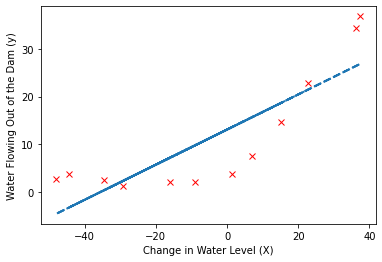

In [60]:
# plot results
plt.plot(X, y, 'rx')
plt.xlabel('Change in Water Level (X)')
plt.ylabel('Water Flowing Out of the Dam (y)')
plt.plot(X, np.dot(X_aug, theta), '--', lw=2)

# Bias-Variance

In [61]:
# create function for calculting learning curves
def learningCurve(X, y, X_val, y_val, lambda_):
    m = y.size
    error_train = np.zeros(m)
    error_val = np.zeros(m)

    for i in range(1, m + 1):
        theta_t = trainLinearReg(linearRegCostFunction, X[:i,:], y[:i], lambda_=lambda_)
        error_train[i - 1], _ = linearRegCostFunction(X[:i], y[:i], theta_t, lambda_=0)
        error_val[i - 1], _ = linearRegCostFunction(X_val, y_val, theta_t, lambda_ = 0)
        
    return error_train, error_val

In [62]:
# test the learning curve
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)


(0.0, 13.0, 0.0, 150.0)

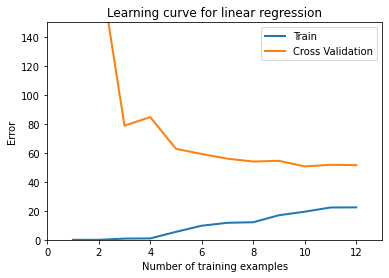

In [63]:
plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])

In [64]:
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	358.961918
  	2		0.000000	193.042992
  	3		0.821649	78.767903
  	4		0.947559	84.645594
  	5		5.480854	62.764038
  	6		9.721981	59.202433
  	7		11.724138	55.949225
  	8		12.115239	54.009281
  	9		16.957054	54.487996
  	10		19.384551	50.638363
  	11		22.290812	51.715005
  	12		22.373906	51.509182


# Polynomial Regression

In [65]:
def polyFeatures(X, p):
    """
    Maps X (a 1-d vector) to the pth power
    """
    X_poly = np.zeros((X.shape[0], p))

    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)

    return X_poly

In [66]:
def featureNormalize(X):
    """
    Returns a normalized version of X with mean=0 and sd=1.
    """
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X, axis=0, ddof=1)
    X_norm /= sigma

    return X_norm, mu, sigma

In [43]:
# create polynomials and normalize
p = 8

X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

In [82]:
# train polynomial model
lambda_ = 100

theta = trainLinearReg(linearRegCostFunction, X_poly, y, lambda_=lambda_)

In [89]:
def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    plt.plot(x, np.dot(X_poly, theta), '--', lw=2)

(-20.0, 50.0)

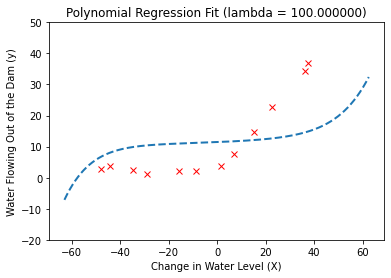

In [92]:
# plot training data and fit
plt.plot(X, y, 'rx')
plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)
plt.xlabel('Change in Water Level (X)')
plt.ylabel('Water Flowing Out of the Dam (y)')
plt.title('Polynomial Regression Fit (lambda = %f)' %lambda_)
plt.ylim([-20, 50])

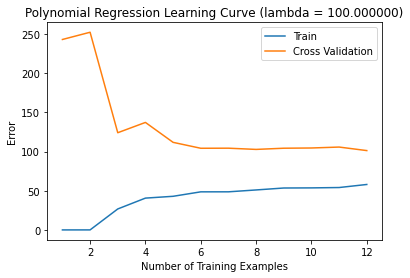

In [96]:
# plot the learning curve
plt.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
plt.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)
plt.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
plt.xlabel('Number of Training Examples')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'])

In [97]:
print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

Polynomial Regression (lambda = 100.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	242.981860
  	2		0.019018	252.219154
  	3		26.739142	124.010722
  	4		40.580293	137.152685
  	5		42.895608	111.728832
  	6		48.584923	104.182096
  	7		48.607147	104.274613
  	8		50.994551	102.724724
  	9		53.472884	104.237810
  	10		53.625530	104.529853
  	11		54.081448	105.717272
  	12		57.977080	101.223841


# Selecting Lambda

In [98]:
def validationCurve(X, y, Xval, yval):
    """
    Plots curves showing error for training and validation sets at varying values of lambda
    """
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    for i in range(len(lambda_vec)):
        lambda_try = lambda_vec[i]
        theta_t = trainLinearReg(linearRegCostFunction, X, y, lambda_=lambda_try)
        error_train[i], _ = linearRegCostFunction(X, y, theta_t, lambda_=0)
        error_val[i], _ = linearRegCostFunction(Xval, yval, theta_t, lambda_=0)

    return lambda_vec, error_train, error_val

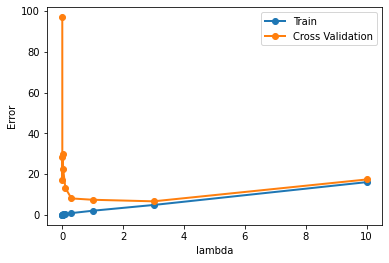

In [100]:
# make the plot
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
plt.xlabel('lambda')
plt.ylabel('Error')
plt.legend(['Train', 'Cross Validation'])

In [101]:
print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

lambda		Train Error	Validation Error
 0.000000	0.028994	96.930466
 0.001000	0.112225	17.177047
 0.003000	0.171039	28.503242
 0.010000	0.221439	29.666325
 0.030000	0.281844	22.450087
 0.100000	0.459317	13.277220
 0.300000	0.921760	8.114457
 1.000000	2.076200	7.456054
 3.000000	4.901377	6.690087
 10.000000	16.092273	17.404720
